**Ho va ten: Do Khanh Dang Khoa**

**MSSV: 19110348**

In [ ]:
#Thư viện
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
batch_size = 128 # batch size để đưa vào mô hình huấn luyện
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #đọc dữ liệu
all_digits = np.concatenate([x_train, x_test]) 
all_digits = all_digits.astype("float32") / 255 #đưa tấm hình về [0,1]
all_digits = np.reshape(all_digits,(-1,28,28,1)) #reshape toàn bộ dữ liệu lại
dataset=tf.data.Dataset.from_tensor_slices(all_digits) #Đưa dữ liệu về dạng tensor
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32) #shuffle dữ liệu mỗi lần đưa vào mô hình

**1. huấn luyện mô hình DCGAN (số chiều của nhiễu là 128) với các mô hình sau đây:**

In [ ]:
#mô hình của mạng Generator
latten_dim=100

generator = keras.Sequential()

generator.add(keras.Input(shape=(latten_dim,)))

generator.add(keras.layers.Dense(units=12544, use_bias=False))
generator.add(keras.layers.Reshape((7,7,256)))

generator.add(keras.layers.BatchNormalization())

generator.add(keras.layers.Conv2DTranspose(filters=128, 
                                           kernel_size=[5,5], 
                                           strides=(1,1), 
                                           padding="same", 
                                           use_bias=False)) 
generator.add(keras.layers.BatchNormalization()) 
generator.add(keras.layers.LeakyReLU(0.2))

generator.add(keras.layers.Conv2DTranspose(filters=64, 
                                           kernel_size=[5,5], 
                                           strides=(2,2), 
                                           padding="same", 
                                           use_bias=False)) 
generator.add(keras.layers.BatchNormalization()) 
generator.add(keras.layers.LeakyReLU(0.2))

generator.add(keras.layers.Conv2DTranspose(filters=1, 
                                           kernel_size=[5,5], 
                                           strides=(2,2), 
                                           padding="same", 
                                           use_bias=False, 
                                           activation="relu")) 
generator.add(keras.layers.Reshape((28,28,1)))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                        

In [ ]:
#mô hình của mạng Discrimimator
discriminator = keras.Sequential()

discriminator.add(keras.Input(shape=(28,28,1)))

discriminator.add(keras.layers.Convolution2D(filters=64,
                                             kernel_size=[5,5],
                                             strides=[2,2],
                                             padding="same"))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))

discriminator.add(keras.layers.Convolution2D(filters=128,
                                             kernel_size=[5,5],
                                             strides=[2,2],
                                             padding="same"))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))

discriminator.add(keras.layers.Flatten())

discriminator.add(keras.layers.Dense(1))

#ta dùng hàm sigmoid để dự đoán cho 2 nhãn
discriminator.add(keras.layers.Activation(activation="sigmoid",name="sigmoid"))  

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
 sigmoid (Activation)        (None, 1)                

In [ ]:
class DCGan(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGan,self).__init__()
        self.discriminator=discriminator 
        self.generator=generator
        self.latent_dim=latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_function):
        super(DCGan,self).compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        self.loss_function=loss_function 
    def train_step(self, real_images):
        # tạo batch size từ dữ liệu đầu vào
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) #tạo noises theo phân phối chuẩn

        # Tạo ra ảnh giả từ mạng generator
        generated_images = self.generator(random_latent_vectors)

        # nối ảnh giả và ảnh thật làm bộ dữ liệu cho mô hình discriminator
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Ở đây đánh nhãn ảnh thật là 1, ảnh giả là 0
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # trick để add thêm noise cho nhãn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # huấn luyện discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images) #Dự đoán 
            d_loss = self.loss_function(labels, predictions)  #Đưa kết quả dự đoán và grouth-truth vào hàm loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        ) #cập nhật weights cho mô hình discrimunator


        # lặp lại bước tạo noise như ở trên
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # tạo mộ bộ nhãn sao cho đều là 1 để đánh lừa discriminator
        misleading_labels = tf.zeros((batch_size, 1))

        # Train generator (lưu ý k update weights cho discriminator)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_function(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


In [ ]:
#overwrite callback để lúc huấn luyện xem ảnh in ra
from IPython.display import Image, display
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) #Tạo noises
        generated_images = self.model.generator(random_latent_vectors) #tạo ảnh
        generated_images *= 255 #Đưa ảnh về [0,255]
        generated_images.numpy() 
        print("epoch ",epoch)
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            display(img) #in ảnh            

In [ ]:
epochs = 30 #số epochs
latent_dim =100 #số chiều cho noises
Dcgan = DCGan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
Dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5), 
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_function=keras.losses.BinaryCrossentropy(),
)

Dcgan.fit(
    dataset, epochs=epochs, callbacks=[DCGANMonitor(num_img=3, latent_dim=latent_dim)],verbose=0
    )


epoch  0


epoch  1


epoch  2


epoch  3


epoch  4


epoch  5


epoch  6


epoch  7


epoch  8


epoch  9


epoch  10


epoch  11


epoch  12


epoch  13


epoch  14


epoch  15


epoch  16


epoch  17


epoch  18


epoch  19


epoch  20


epoch  21


epoch  22


epoch  23


epoch  24


epoch  25


epoch  26


epoch  27


epoch  28


epoch  29


**Câu 2: Từ mô hình GAN đã huấn luyện hãy viết một hàm in ra 10 hình từ noises có phân phối chuẩn**

In [ ]:
#Hàm tao ảnh 
def CreateSamples(Shape):
    random_latent_vectors = tf.random.normal(shape = Shape)
    images = Dcgan.generator(random_latent_vectors)  #tạo ảnh
    images = images*255                              #Đưa ảnh về dạng [0,255]
    images.numpy()                                   #chuyển về dạng numpy
    return images+


In [ ]:
#Tạo ảnh
generated_samples = CreateSamples(Shape =(50,100))

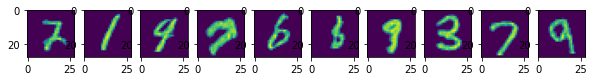

In [ ]:
# In ảnh 
fig, axes = plt.subplots(1,10,figsize=(10, 5))
fig.subplots_adjust(top=1)
for i in range(10):
    create_img = keras.preprocessing.image.array_to_img(generated_samples[i])
    axes[i].imshow(create_img)
  